In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import edge_sim_py as espy
import networkx as nx
import random

In [2]:
headers = [
    "Radio",  # The generation of broadband cellular network technology (Eg. LTE, GSM)
    "MCC",  # Mobile country code. This info is publicly shared by International Telecommunication Union (link)
    "MNC",  # Mobile network code. This info is publicly shared by International Telecommunication Union (link)
    "LAC/TAC/NID",  # Location Area Code
    "CID",  # This is a unique number used to identify each Base transceiver station or sector of BTS
    "Changeable=0",  # The location is directly obtained from the telecom firm
    "Longitude",  # Longitude, is a geographic coordinate that specifies the east-west position of a point on the Earth's surface
    "Latitude",  # Latitude is a geographic coordinate that specifies the north–south position of a point on the Earth's surface.
    "Range",  # Approximate area within which the cell could be. (In meters)
    "Samples",  # Number of measures processed to get a particular data point
    "Changeable=1",  # The location is determined by processing samples
    "Created",  # When a particular cell was first added to database (UNIX timestamp)
    "Updated",  # When a particular cell was last seen (UNIX timestamp)
    "AverageSignal",  # To get the positions of cells, OpenCelliD processes measurements from data contributors. Each measurement includes GPS location of device + Scanned cell identifier (MCC-MNC-LAC-CID) + Other device properties (Signal strength). In this process, signal strength of the device is averaged. Most ‘averageSignal’ values are 0 because OpenCelliD simply didn’t receive signal strength values.
]
df_og = pd.read_csv("../datasets/geo-dataset-724.csv", names=headers)  # , usecols=[4, 6, 7, 8])
df_og

,Radio,MCC,MNC,LAC/TAC/NID,CID,Changeable=0,Longitude,Latitude,Range,Samples,Changeable=1,Created,Updated,AverageSignal
0,GSM,724,5,2151,15463,0,-51.195946,-30.073872,1000,8,1,1459732112,1492009233,0
1,GSM,724,5,332,46623,0,-44.217924,-21.120660,1000,2,1,1459786828,1505328390,0
2,GSM,724,5,849,50103,0,-50.560883,-27.313627,1571,2,1,1459813079,1505870447,0
3,GSM,724,5,3411,20511,0,-46.844001,-23.560824,2109,132,1,1459743036,1506015757,0
4,GSM,724,6,5066,32801,0,-55.523680,-11.794043,2724,5,1,1459703160,1494337597,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864228,LTE,724,2,20442,295,0,-39.463593,-6.852343,1000,1,1,1697111252,1697111252,0
1864229,UMTS,724,5,35911,171144824,0,-46.571392,-23.868881,1000,1,1,1697112151,1697112151,0
1864230,UMTS,724,5,36411,203944027,0,-46.586346,-23.582993,1000,1,1,1697112411,1697112411,0
1864231,LTE,724,2,19726,265,0,-34.980080,-7.478253,1000,1,1,1697118563,1697118563,0


In [3]:
df_og.dtypes

Radio             object
MCC                int64
MNC                int64
LAC/TAC/NID        int64
CID                int64
Changeable=0       int64
Longitude        float64
Latitude         float64
Range              int64
Samples            int64
Changeable=1       int64
Created            int64
Updated            int64
AverageSignal      int64
dtype: object

In [4]:
# ---------------
# | 0,0       0,1
# |
# | 1,0       1,1
# ---------------
# Latitude, Longitude (x, y)
# ---------------
# | +1,-1   +1,+0   +1,+1
# |
# | +0,-1   +0,+0   +1,+0
# |
# | -1,-1   -1,+0   +1,-1
# ---------------
# São Paulo
coord_start = { "Latitude": -23.438893, "Longitude": -46.324440 }
coord_final = { "Latitude": -23.814428, "Longitude": -46.911431 }

# Joinville
coord_start = { "Latitude": -26.200431, "Longitude": -48.748822 }
coord_final = { "Latitude": -26.376193, "Longitude": -48.945546 }

df = df_og.copy()

df = df.loc[df.Latitude <= coord_start["Latitude"]]
df = df.loc[df.Longitude <= coord_start["Longitude"]]

df = df.loc[df.Latitude >= coord_final["Latitude"]]
df = df.loc[df.Longitude >= coord_final["Longitude"]]

df = df.reset_index(drop=True)
df

,Radio,MCC,MNC,LAC/TAC/NID,CID,Changeable=0,Longitude,Latitude,Range,Samples,Changeable=1,Created,Updated,AverageSignal
0,GSM,724,16,4701,1682,0,-48.795090,-26.282730,1000,5,1,1223561212,1223561212,0
1,GSM,724,16,4701,1468,0,-48.799687,-26.268251,1674,46,1,1223580558,1239201914,0
2,GSM,724,16,4701,1593,0,-48.812587,-26.269779,2262,116,1,1223580558,1239201917,0
3,GSM,724,16,4701,591,0,-48.848158,-26.290970,1000,14,1,1223560849,1223560849,0
4,GSM,724,16,4701,593,0,-48.848373,-26.290970,1000,5,1,1223560849,1223560849,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4867,LTE,724,5,40047,120346637,-1,-48.853580,-26.284048,1000,2,1,1696941365,1696985464,0
4868,LTE,724,5,40047,120346626,-1,-48.853915,-26.282490,1000,3,1,1696941385,1696985464,0
4869,LTE,724,5,40047,120404766,-1,-48.844910,-26.266655,1000,1,1,1696941795,1696941795,0
4870,UMTS,724,5,30047,16283439,8,-48.844614,-26.265038,1000,5,1,1696941815,1696985464,0


In [5]:
df_norm = df.copy()
lower, upper = 0, 100

lat_min, lat_max = df_norm.Latitude.min(), df_norm.Latitude.max()
df_norm.Latitude = (df_norm.Latitude - lat_min) / (lat_max - lat_min) * (upper - lower) + lower
df_norm.Latitude = df_norm.Latitude.astype(np.int64)

lon_min, lon_max = df_norm.Longitude.min(), df_norm.Longitude.max()
df_norm.Longitude = (df_norm.Longitude - lon_min) / (lon_max - lon_min) * (upper - lower) + lower
df_norm.Longitude = df_norm.Longitude.astype(np.int64)

print(df_norm[['Latitude', 'Longitude']].value_counts())

df_norm

Latitude  Longitude
69        47           35
41        50           18
42        49           17
39        47           16
40        50           16
                       ..
39        62            1
          61            1
          55            1
          37            1
100       18            1
Length: 2389, dtype: int64


,Radio,MCC,MNC,LAC/TAC/NID,CID,Changeable=0,Longitude,Latitude,Range,Samples,Changeable=1,Created,Updated,AverageSignal
0,GSM,724,16,4701,1682,0,77,53,1000,5,1,1223561212,1223561212,0
1,GSM,724,16,4701,1468,0,75,61,1674,46,1,1223580558,1239201914,0
2,GSM,724,16,4701,1593,0,68,60,2262,116,1,1223580558,1239201917,0
3,GSM,724,16,4701,591,0,50,48,1000,14,1,1223560849,1223560849,0
4,GSM,724,16,4701,593,0,50,48,1000,5,1,1223560849,1223560849,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4867,LTE,724,5,40047,120346637,-1,47,52,1000,2,1,1696941365,1696985464,0
4868,LTE,724,5,40047,120346626,-1,47,53,1000,3,1,1696941385,1696985464,0
4869,LTE,724,5,40047,120404766,-1,52,62,1000,1,1,1696941795,1696941795,0
4870,UMTS,724,5,30047,16283439,8,52,63,1000,5,1,1696941815,1696985464,0


In [6]:
df_dedup = df_norm.copy()
df_dedup = df_dedup.drop_duplicates(subset=['Latitude', 'Longitude'])

df_dedup

,Radio,MCC,MNC,LAC/TAC/NID,CID,Changeable=0,Longitude,Latitude,Range,Samples,Changeable=1,Created,Updated,AverageSignal
0,GSM,724,16,4701,1682,0,77,53,1000,5,1,1223561212,1223561212,0
1,GSM,724,16,4701,1468,0,75,61,1674,46,1,1223580558,1239201914,0
2,GSM,724,16,4701,1593,0,68,60,2262,116,1,1223580558,1239201917,0
3,GSM,724,16,4701,591,0,50,48,1000,14,1,1223560849,1223560849,0
5,GSM,724,5,147,12865,0,51,39,1000,10,1,1223575302,1223575302,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4831,LTE,724,5,40047,120569614,-1,38,47,1000,4,1,1689685898,1689685916,0
4833,GSM,724,4,27947,17912,-1,40,43,1976,132,1,1690688991,1690751078,0
4855,GSM,724,5,1547,10665,-1,54,24,500,127,1,1691003536,1692280817,0
4861,UMTS,724,5,30047,16283373,381,54,45,1000,1,1,1691593220,1691593220,0


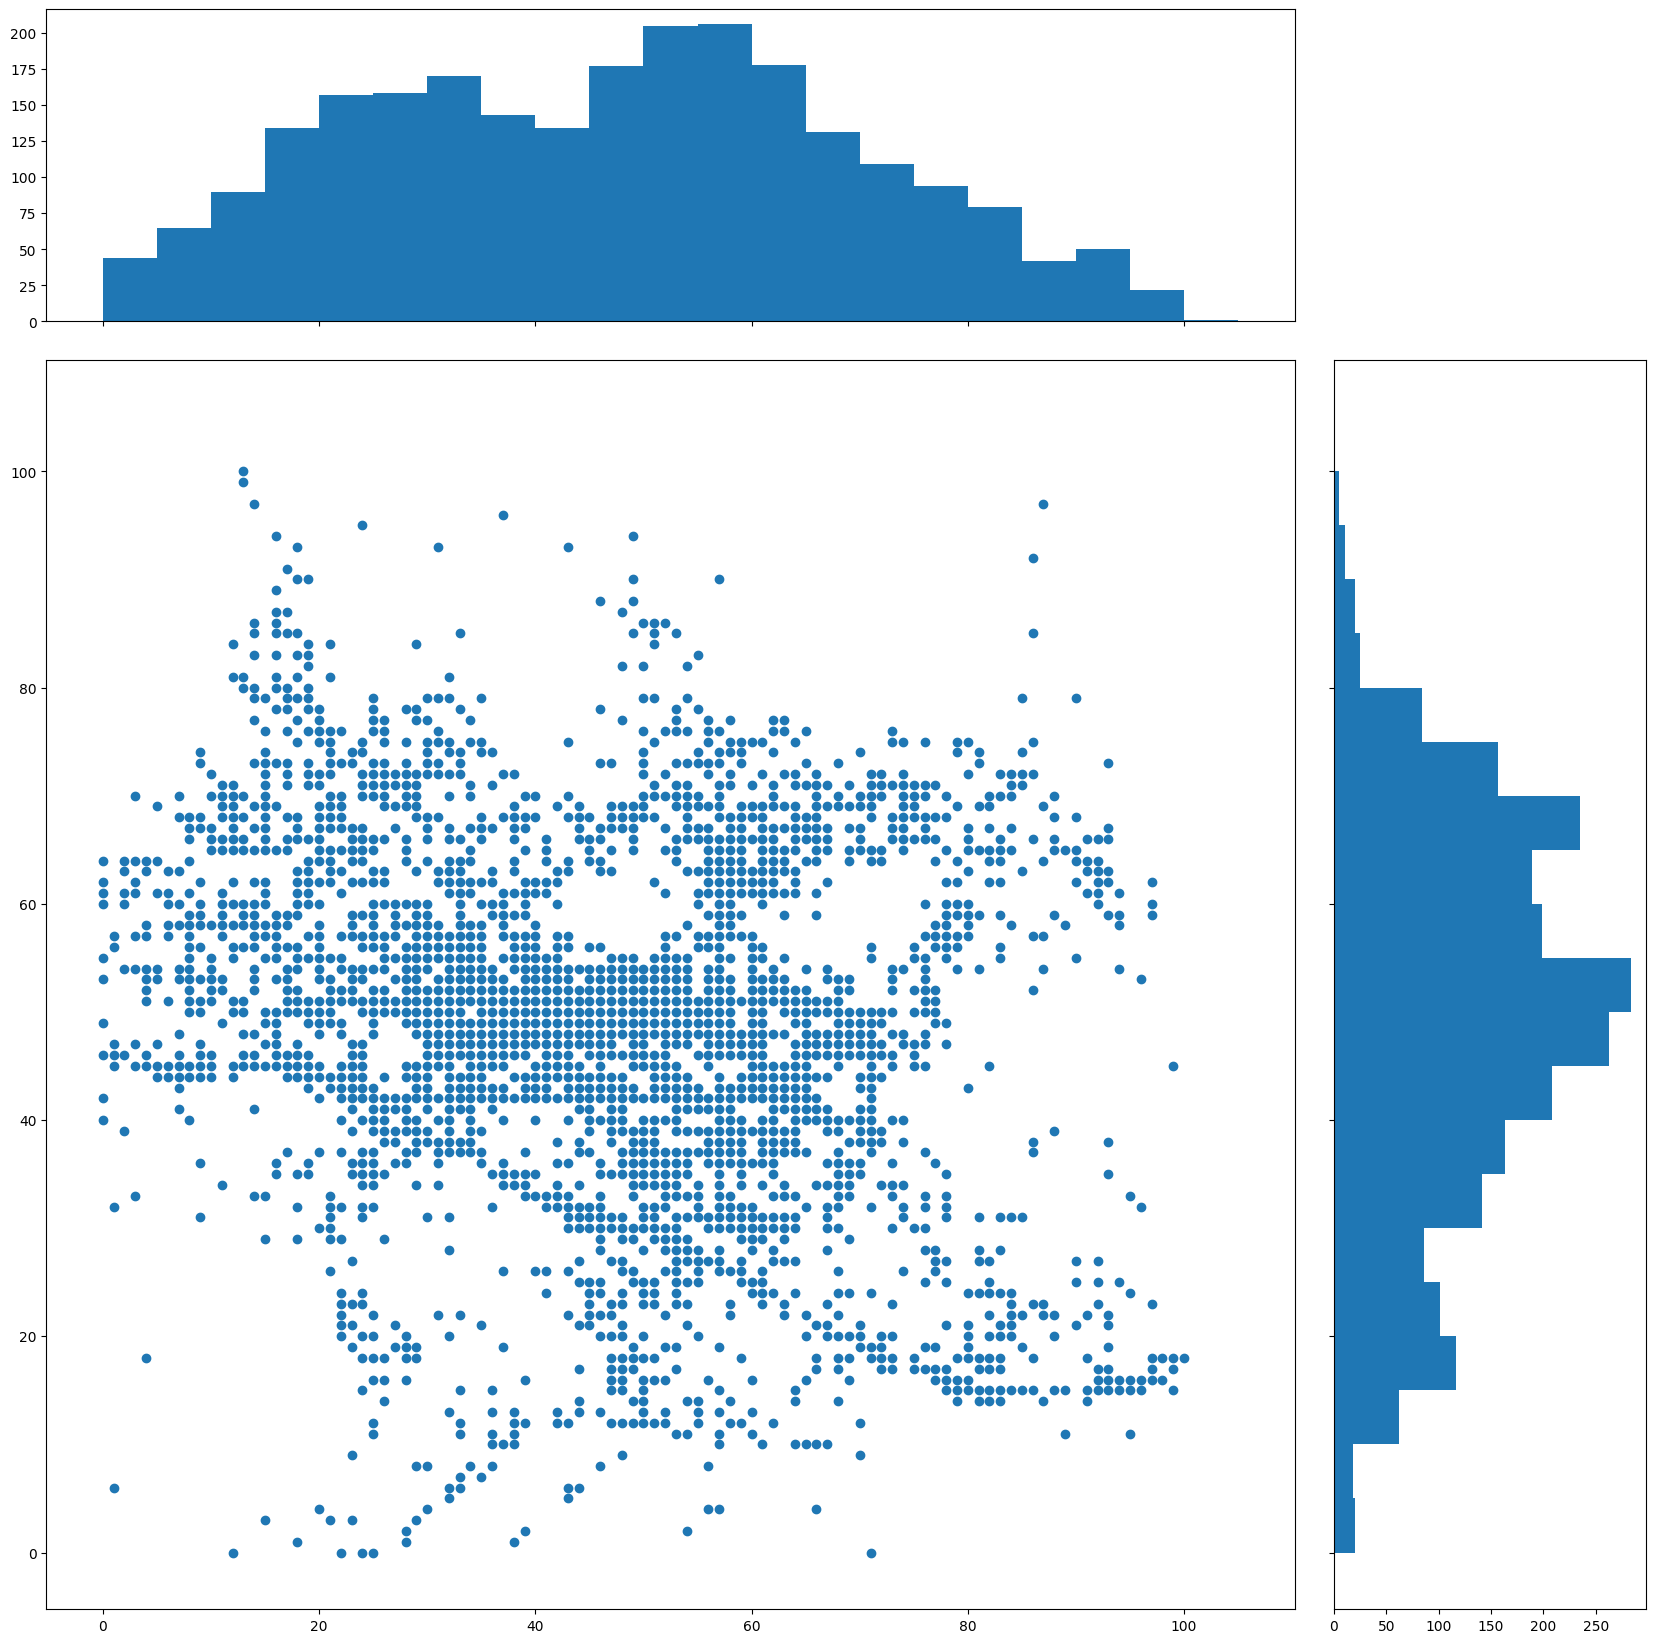

In [7]:
x, y = df_dedup.Latitude.copy(), df_dedup.Longitude.copy()

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 5
    lim = (int(upper/binwidth) + 1) * binwidth

    bins = np.arange(0, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

# Start with a square Figure.
fig = plt.figure(figsize=(20, 20))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# fig.set_facecolor('grey')
# ax.set_facecolor('grey')
# ax_histx.set_facecolor('grey')
# ax_histy.set_facecolor('grey')
# Draw the scatter plot and marginals.
scatter_hist(x, y, ax, ax_histx, ax_histy)

In [8]:
coordinates_df = df_dedup[['Latitude', 'Longitude']]

coordinates_df

,Latitude,Longitude
0,53,77
1,61,75
2,60,68
3,48,50
5,39,51
...,...,...
4831,47,38
4833,43,40
4855,24,54
4861,45,54


In [9]:
map_coordinates = espy.hexagonal_grid(x_size=upper, y_size=upper)

map_coordinates

[(0, 0),
 (2, 0),
 (4, 0),
 (6, 0),
 (8, 0),
 (10, 0),
 (12, 0),
 (14, 0),
 (16, 0),
 (18, 0),
 (20, 0),
 (22, 0),
 (24, 0),
 (26, 0),
 (28, 0),
 (30, 0),
 (32, 0),
 (34, 0),
 (36, 0),
 (38, 0),
 (40, 0),
 (42, 0),
 (44, 0),
 (46, 0),
 (48, 0),
 (50, 0),
 (52, 0),
 (54, 0),
 (56, 0),
 (58, 0),
 (60, 0),
 (62, 0),
 (64, 0),
 (66, 0),
 (68, 0),
 (70, 0),
 (72, 0),
 (74, 0),
 (76, 0),
 (78, 0),
 (80, 0),
 (82, 0),
 (84, 0),
 (86, 0),
 (88, 0),
 (90, 0),
 (92, 0),
 (94, 0),
 (96, 0),
 (98, 0),
 (100, 0),
 (102, 0),
 (104, 0),
 (106, 0),
 (108, 0),
 (110, 0),
 (112, 0),
 (114, 0),
 (116, 0),
 (118, 0),
 (120, 0),
 (122, 0),
 (124, 0),
 (126, 0),
 (128, 0),
 (130, 0),
 (132, 0),
 (134, 0),
 (136, 0),
 (138, 0),
 (140, 0),
 (142, 0),
 (144, 0),
 (146, 0),
 (148, 0),
 (150, 0),
 (152, 0),
 (154, 0),
 (156, 0),
 (158, 0),
 (160, 0),
 (162, 0),
 (164, 0),
 (166, 0),
 (168, 0),
 (170, 0),
 (172, 0),
 (174, 0),
 (176, 0),
 (178, 0),
 (180, 0),
 (182, 0),
 (184, 0),
 (186, 0),
 (188, 0),
 (190, 0),

In [10]:
for coordinates in map_coordinates:
    base_station = espy.BaseStation()
    base_station.coordinates = coordinates

    network_switch = espy.sample_switch()
    base_station._connect_to_network_switch(network_switch=network_switch)

In [11]:
# def find_neighbors_hexagonal_grid(map_coordinates: list, current_position: tuple) -> list:
#     x = current_position[0]
#     y = current_position[1]

#     candidates = [(x - 2, y), (x - 1, y + 1), (x + 1, y + 1), (x + 2, y), (x + 1, y - 1), (x - 1, y - 1)]

#     neighbors = [
#         neighbor
#         for neighbor in candidates
#         if neighbor[0] >= 0 and neighbor[1] >= 0 and (neighbor[0], neighbor[1]) in map_coordinates
#     ]

#     return neighbors

In [12]:
# network_nodes = espy.NetworkSwitch.all()
# topology = espy.Topology()
# topology.add_nodes_from(network_nodes)

# # Gathering the list of coordinates of all network nodes
# map_coordinates = [node.coordinates for node in network_nodes]

# # Adding links to each network node
# for node in network_nodes:
#     neighbors = find_neighbors_hexagonal_grid(current_position=node.coordinates, map_coordinates=map_coordinates)

#     for neighbor_coordinates in neighbors:
#         neighbor = next((n for n in network_nodes if n.coordinates == neighbor_coordinates), None)

#         if not neighbor:
#             raise Exception(f"Cannot find network node with coordinates: {neighbor_coordinates}")

#         # Creating network link object
#         if not topology.has_edge(node, neighbor):
#             link = espy.NetworkLink()
#             link.topology = topology

#             # List of network nodes connected by the link
#             link.nodes = [node, neighbor]

#             # Replacing NetworkX's default link dictionary with the NetworkLink object
#             topology.add_edge(node, neighbor)
#             topology._adj[node][neighbor] = link
#             topology._adj[neighbor][node] = link

# len(topology.edges)

In [13]:
topology = espy.partially_connected_hexagonal_mesh(
    network_nodes=espy.NetworkSwitch.all(),
    link_specifications=[
        {"number_of_objects": 29601, "delay": 1, "bandwidth": 10}
    ]
)

topology

Topology_1

In [14]:
def sgi_rackable_c2112_4g10() -> object:
    """Creates an EdgeServer object according to XXXX [TODO].

    Returns:
        edge_server (object): Created EdgeServer object.
    """
    edge_server = espy.EdgeServer()
    # edge_server.model_name = "SGI Rackable C2112-4G10"
    edge_server.model_name = "SGI"

    # Computational capacity (CPU in cores, RAM memory in megabytes, and disk in megabytes)
    edge_server.cpu = 32
    edge_server.memory = 32768
    edge_server.disk = 1048576
    edge_server.mips = 2750

    # Power-related attributes
    edge_server.power_model_parameters = {
        "static_power_percentage": 265 / 1387,
        "max_power_consumption": 1387,
    }

    return edge_server

def proliant_dl360_gen9() -> object:
    """Creates an EdgeServer object according to XXXX [TODO].

    Returns:
        edge_server (object): Created EdgeServer object.
    """
    edge_server = espy.EdgeServer()
    # edge_server.model_name = "HPE ProLiant DL360 Gen9"
    edge_server.model_name = "HPE"

    # Computational capacity (CPU in cores, RAM memory in megabytes, and disk in megabytes)
    edge_server.cpu = 36
    edge_server.memory = 65536
    edge_server.disk = 1048576
    edge_server.mips = 3000

    # Power-related attributes
    edge_server.power_model_parameters = {
        "static_power_percentage": 45 / 276,
        "max_power_consumption": 276,
    }

    return edge_server


def ar585_f1() -> object:
    """Creates an EdgeServer object according to XXXX [TODO].

    Returns:
        edge_server (object): Created EdgeServer object.
    """
    edge_server = espy.EdgeServer()
    # edge_server.model_name = "Acer AR585 F1"
    edge_server.model_name = "Acer"

    # Computational capacity (CPU in cores, RAM memory in megabytes, and disk in megabytes)
    edge_server.cpu = 48
    edge_server.memory = 65536
    edge_server.disk = 1048576
    edge_server.mips = 3500

    # Power-related attributes
    edge_server.power_model_parameters = {
        "static_power_percentage": 127 / 559,
        "max_power_consumption": 559,
    }

    return edge_server


# Creating edge servers
SERVERS_PER_SPEC_TRUSTED_PROVIDERS = 1
SERVERS_PER_SPEC_UNTRUSTED_PROVIDER = 4
provider_specs = [
    {
        "id": 1,
        "edge_server_specs": [
            {"spec": sgi_rackable_c2112_4g10, "number_of_objects": SERVERS_PER_SPEC_TRUSTED_PROVIDERS},
            {"spec": proliant_dl360_gen9, "number_of_objects": SERVERS_PER_SPEC_TRUSTED_PROVIDERS},
            {"spec": ar585_f1, "number_of_objects": SERVERS_PER_SPEC_TRUSTED_PROVIDERS},
        ],
    },
    {
        "id": 2,
        "edge_server_specs": [
            {"spec": sgi_rackable_c2112_4g10, "number_of_objects": SERVERS_PER_SPEC_TRUSTED_PROVIDERS},
            {"spec": proliant_dl360_gen9, "number_of_objects": SERVERS_PER_SPEC_TRUSTED_PROVIDERS},
            {"spec": ar585_f1, "number_of_objects": SERVERS_PER_SPEC_TRUSTED_PROVIDERS},
        ],
    },
    {
        "id": 3,
        "edge_server_specs": [
            {"spec": sgi_rackable_c2112_4g10, "number_of_objects": SERVERS_PER_SPEC_UNTRUSTED_PROVIDER},
            {"spec": proliant_dl360_gen9, "number_of_objects": SERVERS_PER_SPEC_UNTRUSTED_PROVIDER},
            {"spec": ar585_f1, "number_of_objects": SERVERS_PER_SPEC_UNTRUSTED_PROVIDER},
        ],
    },
]

In [15]:
# Creating clusters of network switches based on the number of specified edge servers
number_of_edge_servers = 0
for provider in provider_specs:
    number_of_edge_servers += sum([spec["number_of_objects"] for spec in provider["edge_server_specs"]])
kmeans = KMeans(init="k-means++", n_init=100, n_clusters=number_of_edge_servers, random_state=0, max_iter=1000).fit(
    [switch.coordinates for switch in espy.NetworkSwitch.all()]
)
node_clusters = list(kmeans.labels_)
edge_server_coordinates = []
for centroid in list(kmeans.cluster_centers_):
    node_closest_to_centroid = sorted(
        espy.NetworkSwitch.all(),
        key=lambda switch: np.linalg.norm(np.array(switch.coordinates) - np.array([centroid[0], centroid[1]])),
    )[0]
    edge_server_coordinates.append(node_closest_to_centroid.coordinates)
edge_server_coordinates = random.sample(edge_server_coordinates, len(edge_server_coordinates))

for provider_spec in provider_specs:
    for edge_server_spec in provider_spec["edge_server_specs"]:
        for _ in range(edge_server_spec["number_of_objects"]):
            # Creating the edge server object
            edge_server = edge_server_spec["spec"]()

            # Defining the maximum number of layers that the edge server can pull simultaneously
            edge_server.max_concurrent_layer_downloads = 3

            # Specifying the edge server's power model
            edge_server.power_model = espy.LinearServerPowerModel

            # Edge server's infrastructure provider
            edge_server.infrastructure_provider = provider_spec["id"]

            # Connecting the edge server to a random base station
            # base_stations_without_edge_servers = [bs for bs in BaseStation.all() if len(bs.edge_servers) == 0]
            # base_station = random.sample(base_stations_without_edge_servers, 1)[0]
            base_station: espy.BaseStation = espy.BaseStation.find_by(
                attribute_name="coordinates", attribute_value=edge_server_coordinates[edge_server.id - 1]
            ) # type: ignore
            base_station._connect_to_edge_server(edge_server=edge_server)

In [ ]:
topology = espy.Topology.first()
# Customizing visual representation of topology
positions = {}
labels = {}
colors = []
sizes = []

# Gathering the coordinates of edge servers
edge_server_coordinates = [edge_server.coordinates for edge_server in espy.EdgeServer.all()]

# Defining list of color options
color_options = []
for _ in range(espy.EdgeServer.count()):
    color_options.append([random.random(), random.random(), random.random()])

for node in topology.nodes():
    positions[node] = node.coordinates
    labels[node] = node.id
    node_size = 500 if any(user.coordinates == node.coordinates for user in espy.User.all()) else 100
    sizes.append(node_size)

    if node.coordinates in edge_server_coordinates:
        colors.append("red")
        # colors.append([primary_color_value / 3 for primary_color_value in color_options[node_clusters[node.id - 1]]])
    else:
        colors.append("black")
        # colors.append(color_options[node_clusters[node.id - 1]])

# Configuring drawing scheme
nx.draw(
    topology,
    pos=positions,
    node_color=colors,
    node_size=sizes,
    labels=labels,
    font_size=6,
    font_weight="bold",
    font_color="whitesmoke",
)

# Saving a topology image in the disk
# plt.savefig(f"{output_filename}.png", dpi=120)
plt.show()

In [16]:
espy.ComponentManager.export_scenario(save_to_file=True, file_name="dataset_test")

{'NetworkSwitch': [{'attributes': {'id': 1,
    'coordinates': (0, 0),
    'active': True,
    'power_model_parameters': {'chassis_power': 60,
     'ports_power_consumption': {'125': 1, '12.5': 0.3}}},
   'relationships': {'power_model': 'ConteratoNetworkPowerModel',
    'edge_servers': [],
    'links': [],
    'base_station': {'class': 'BaseStation', 'id': 1}}},
  {'attributes': {'id': 2,
    'coordinates': (2, 0),
    'active': True,
    'power_model_parameters': {'chassis_power': 60,
     'ports_power_consumption': {'125': 1, '12.5': 0.3}}},
   'relationships': {'power_model': 'ConteratoNetworkPowerModel',
    'edge_servers': [],
    'links': [],
    'base_station': {'class': 'BaseStation', 'id': 2}}},
  {'attributes': {'id': 3,
    'coordinates': (4, 0),
    'active': True,
    'power_model_parameters': {'chassis_power': 60,
     'ports_power_consumption': {'125': 1, '12.5': 0.3}}},
   'relationships': {'power_model': 'ConteratoNetworkPowerModel',
    'edge_servers': [],
    'links

In [22]:
def my_algorithm(parameters):
    # We can always call the 'all()' method to get a list with all created instances of a given class
    for service in espy.Service.all():
        # We don't want to migrate services are are already being migrated
        if service.server == None and not service.being_provisioned:
            # Let's iterate over the list of edge servers to find a suitable host for our service
            for edge_server in espy.EdgeServer.all():
                # We must check if the edge server has enough resources to host the service
                if edge_server.has_capacity_to_host(service=service):
                    # Start provisioning the service in the edge server
                    service.provision(target_server=edge_server)
                    # After start migrating the service we can move on to the next service
                    break


def stopping_criterion(model: object):
    # Defining a variable that will help us to count the number of services successfully provisioned within the infrastructure
    provisioned_services = 0
    # Iterating over the list of services to count the number of services provisioned within the infrastructure
    for service in espy.Service.all():
        # Initially, services are not hosted by any server (i.e., their "server" attribute is None).
        # Once that value changes, we know that it has been successfully provisioned inside an edge server.
        if service.server != None:
            provisioned_services += 1
    # As EdgeSimPy will halt the simulation whenever this function returns True, its output will be a boolean expression
    # that checks if the number of provisioned services equals to the number of services spawned in our simulation
    return provisioned_services == espy.Service.count()

In [49]:
simulator = espy.Simulator(
    dump_interval=5,
    tick_duration=1,
    tick_unit="seconds",
    stopping_criterion=stopping_criterion,
    resource_management_algorithm=my_algorithm,
)

simulator.initialize(input_file="../datasets/dataset.json")

# G = nx.Graph()
# topology = espy.Topology(existing_graph=G)

# simulator.initialize_agent(topology)
# simulator.topology = topology

# simulator.run_model()

In [50]:
all_topologies = espy.Topology.all()
for t in all_topologies:
    print(t._to_dict())

{'attributes': {'id': 1}}


In [ ]:
for ns in espy.NetworkLink.all():
    print(ns._to_dict())

In [ ]:
for bs in espy.BaseStation.all():
    print(bs._to_dict())

In [ ]:
for ns in espy.NetworkSwitch.all():
    print(ns._to_dict())

In [ ]:
simulator.initialize_agent(espy.NetworkSwitch(20))
for ns in espy.NetworkSwitch.all():
    print(ns._to_dict())

switch = espy.NetworkSwitch()
# switch.edge_servers = None
# switch._to_dict()

In [31]:
for nf in espy.NetworkFlow.all():
    print(nf._to_dict())

In [ ]:
for es in espy.EdgeServer.all():
    print(es._to_dict())